In [15]:
from parcels import *
import numpy as np
import math
from datetime import timedelta as delta
from operator import attrgetter
import netCDF4
import pandas
import os
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from matplotlib.pyplot import hold, figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show, savefig
import cmocean as cm
%matplotlib inline

In [14]:
globfiles = ["/Users/hart-davis/Desktop/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU.nc"]
globfile = ["/Users/hart-davis/Desktop/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV.nc"]

filenames = {'U': globfiles,
             'V': globfile}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty'}
dimensions = {'lat': 'nav_lat',
              'lon': 'nav_lon',
              'time': 'time_counter'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

lonW = -70  #western part of deployment box
lonE = 56  #eastern part of deployment box
latS = -70 #southern part of deployment box
latN = -30 #northern part of deployment box
particles = 10 #number of particles one wants to deploy

lons, lats = np.meshgrid(np.arange(lonW, lonE, 2), np.arange(latS, latN,2))
pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)

os.remove("testing3.nc")
output_file = pset.ParticleFile(name="testing3")
pset.execute(AdvectionRK4, starttime=datetime(2008, 1, 1), runtime=timedelta(days=1000),
             dt=timedelta(minutes=5), interval=timedelta(hours=6),output_file=output_file)
nc = netCDF4.Dataset("testing3.nc")
lon = nc.variables["lon"][:]
lat = nc.variables["lat"][:]

ncd = netCDF4.Dataset('/Users/hart-davis/Desktop/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU.nc')
ncf = netCDF4.Dataset('/Users/hart-davis/Desktop/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV.nc')

lonx = ncd.variables["nav_lon"][:]
laty = ncd.variables["nav_lat"][:]
east = ncd.variables["vozocrtx"][0,0]
north = ncf.variables["vomecrty"][0,0]
figure1 = plt.figure(figsize=(13, 10), dpi=80, facecolor='w', edgecolor='k')

m = Basemap(projection = "merc", resolution="i",llcrnrlon = -70, 
            llcrnrlat = -70, urcrnrlon = 56, urcrnrlat = -29,lat_0= -20,lon_0 = 0)
f1,f2 = m(lon,lat)
for i in range(0,len(f1[0]-1)):
    m.scatter(f1[:,i],f2[:,i],1, marker = ".", alpha = 1, zorder=3)

x,y = m(lonx,laty)

speed = np.sqrt(np.square(east) + np.square(north))
#Blue=GC
#Red = Hycom
m.streamplot(x,y,east,north,color=speed,density=3, cmap=plt.cm.bone, linewidth=speed/2)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
#m.bluemarble()
m.drawparallels(np.arange(-90.,99.,10), color="k",labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,180.,10), color="k",labels=[0,0,0,1],fontsize=15)

plt.show()

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/r4/54mc4t2559d_d1fnkl99m38r0000gn/T/parcels-501/27805ff3aa34ba12ddb373f3f2cb1d1b.so


KeyboardInterrupt: 

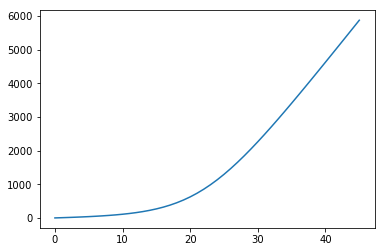

In [18]:
plt.show(plt.plot(deptht))

In [66]:
def set_ofes_fieldset(snapshots):
    ufiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU0"+str(s)+".nc" for s in snapshots]
    vfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV0"+str(s)+".nc" for s in snapshots]
    wfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridW0"+str(s)+".nc" for s in snapshots]
    tfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridT0"+str(s)+".nc" for s in snapshots]
    filenames = {'U': ufiles, 'V': vfiles, 'W': wfiles, 'temp': tfiles}
    variables = {'U': 'vozocrtx','V': 'vomecrty','W': 'vovecrtz', 'temp':'votemper'}
    dimensions = {'lat': 'nav_lat','lon': 'nav_lon','time': 'time_counter','depth':'depth'}
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation=True)
    fieldset.U.data # convert from cm/s to m/s
    fieldset.V.data # convert from cm/s to m/s
    fieldset.W.data  # convert from cm/s to m/s
    return fieldset

def SampleTemp(particle, fieldset, time, dt):
    particle.temp = fieldset.temp[time, particle.lon, particle.lat, particle.depth]


def Sink(particle, fieldset, time, dt):
    if particle.depth > fieldset.dwellingdepth:
        particle.depth = particle.depth + fieldset.sinkspeed * dt
    else:
        particle.depth = fieldset.dwellingdepth


def Age(particle, fieldset, time, dt):
    if particle.depth <= fieldset.dwellingdepth:
        particle.age = particle.age + math.fabs(dt)
    if particle.age > fieldset.maxage:
        particle.delete()


def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()


def run_corefootprintparticles(outfile):
    snapshots = range(0, 7)
    fieldset = set_ofes_fieldset(snapshots[-4:-1])
    fieldset.add_constant('dwellingdepth', 0)
    fieldset.add_constant('sinkspeed', 1000/3600)
    fieldset.add_constant('maxage', 30.*86400)

    corelon = [17.30]
    corelat = [-34.70]
    coredepth = [1000]

    class ForamParticle(JITParticle):
        temp = Variable('temp', dtype=np.float32, initial=np.nan)
        age = Variable('age', dtype=np.float32, initial=0.)

    pset = ParticleSet(fieldset=fieldset, pclass=ForamParticle, lon=corelon, lat=corelat,
                       depth=coredepth, time=fieldset.U.time[-1])
    pfile = ParticleFile(outfile, pset, type="indexed")
    pfile.write(pset, pset[0].time)

    kernels = pset.Kernel(AdvectionRK4_3D) + Sink + SampleTemp + Age

    pbar = ProgressBar()
    for s in pbar(range(len(snapshots)-5, -1, -1)):
        pset.execute(kernels, starttime=pset[0].time, runtime=delta(days=30),
                     dt=delta(minutes=-5), interval=delta(days=-1),
                     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

        pset.add(ForamParticle(lon=corelon, lat=corelat, depth=coredepth, fieldset=fieldset))
        pfile.write(pset, pset[0].time)

def make_plot(trajfile):
    from netCDF4 import Dataset
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap

    class ParticleData(object):
        def __init__(self):
            self.id = []

    def load_particles_file(fname, varnames):
        T = ParticleData()
        pfile = Dataset(fname, 'r')
        T.id = pfile.variables['trajectory'][:]
        for v in varnames:
            setattr(T, v, pfile.variables[v][:])
        return T

    T = load_particles_file(trajfile, ['lon', 'lat', 'temp', 'z'])
    m = Basemap(projection='merc', llcrnrlat=-40, urcrnrlat=-27.5, llcrnrlon=10, urcrnrlon=32.5, resolution='h')
    m.drawcoastlines()
    m.fillcontinents(color='burlywood')
    m.drawparallels(np.arange(-50, -20, 10), labels=[True, False, False, False])
    m.drawmeridians(np.arange(0, 40, 10), labels=[False, False, False, True])

    sinks = np.where(T.z > 50.)
    dwell = np.where(T.z == 50.)
    xs, ys = m(T.lon[dwell], T.lat[dwell])
    m.scatter(xs, ys, c=T.temp[dwell], s=5)
    cbar = plt.colorbar()
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel('[$^\circ$C]')

    xs, ys = m(T.lon[sinks], T.lat[sinks])
    m.scatter(xs, ys, c='k', s=5)
    xs, ys = m(T.lon[0, 0], T.lat[0, 0])
    m.plot(xs, ys, 'om')
    plt.show()


INFO: Note that positive vertical velocity is assumed DOWNWARD by AdvectionRK4_3D
INFO: Compiled ForamParticleAdvectionRK4_3DSinkSampleTempAge ==> /var/folders/r4/54mc4t2559d_d1fnkl99m38r0000gn/T/parcels-501/af4b48415baa5482478b0e0fea338f26.so
100% |########################################################################|
100% |########################################################################|
/Users/hart-davis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in greater


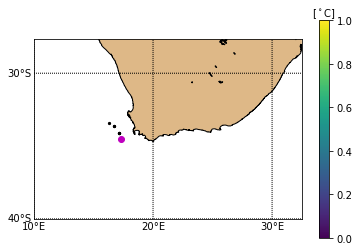

In [67]:
os.remove("corefootprint_particles.nc")
outfile = "corefootprint_particles"

run_corefootprintparticles(outfile)
convert_IndexedOutputToArray(file_in=outfile+".nc", file_out=outfile+"_array.nc")
make_plot(outfile+"_array.nc")

In [33]:
nc = netCDF4.Dataset("/Users/hart-davis/Desktop/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU.nc")

In [39]:
int(nc.variables["time_counter"][0])

599184000

In [76]:
snapshots = range(1,2)

ufiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU0"+str(s)+".nc" for s in snapshots]
vfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV0"+str(s)+".nc" for s in snapshots]
wfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridW0"+str(s)+".nc" for s in snapshots]
tfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridT0"+str(s)+".nc" for s in snapshots]
filenames = {'U': ufiles, 'V': vfiles, 'W': wfiles, 'temp': tfiles}
variables = {'U': 'vozocrtx','V': 'vomecrty','W': 'vovecrtz', 'temp':'votemper'}
dimensions = {'lat': 'nav_lat','lon': 'nav_lon','time': 'time_counter','depth':'depth'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation=True)

fieldset = set_ofes_fieldset(snapshots[:])
fieldset.add_constant('dwellingdepth', 1000)
fieldset.add_constant('sinkspeed', 1000/3600)
fieldset.add_constant('maxage', 30.*86400)
    

def Sink(particle, fieldset, time, dt):
    if particle.depth > fieldset.dwellingdepth:
        particle.depth = particle.depth + fieldset.sinkspeed * dt
    else:
        particle.depth = fieldset.dwellingdepth    
    

In [109]:
kernels = pset.Kernel(AdvectionRK4_3D) + Sink

lonW = -10  #western part of deployment box
lonE = 10  #eastern part of deployment box
latS = -65 #southern part of deployment box
latN = -55 #northern part of deployment box
npart = 100

lons = np. linspace (lonW, lonE, npart , dtype =np. float32 )
lats = np. linspace (latS, latN, npart , dtype =np. float32 )

pset = ParticleSet( fieldset , lon=lons, lat=lats)

os.remove("testing3.nc")
output_file = pset.ParticleFile(name="testing3")
pset.execute(AdvectionRK4, starttime=datetime(2008, 1, 1), runtime=timedelta(days=70),
             dt=timedelta(minutes=5), interval=timedelta(hours=6),output_file=output_file)


INFO: Note that positive vertical velocity is assumed DOWNWARD by AdvectionRK4_3D
INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/r4/54mc4t2559d_d1fnkl99m38r0000gn/T/parcels-501/27805ff3aa34ba12ddb373f3f2cb1d1b.so


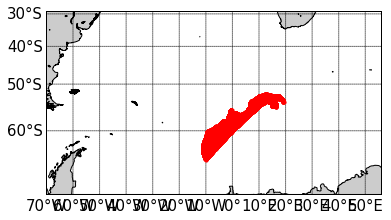

In [110]:
nc = netCDF4.Dataset("testing3.nc")
lon = nc.variables["lon"][:]
lat = nc.variables["lat"][:]
depth = nc.variables["z"][:]

m = Basemap(projection = "merc", resolution="i",llcrnrlon = -70, 
            llcrnrlat = -70, urcrnrlon = 56, urcrnrlat = -29,lat_0= -20,lon_0 = 0)
f1,f2 = m(lon,lat)
m.scatter(f1,f2,10,color="red", marker = "o", alpha = 1, zorder=3)

#Blue=GC
#Red = Hycom

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
#m.bluemarble()
m.drawparallels(np.arange(-90.,99.,10), color="k",labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,180.,10), color="k",labels=[0,0,0,1],fontsize=15)

plt.show()

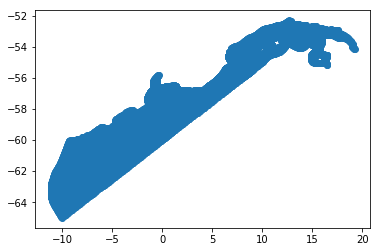

In [111]:
plt.scatter(lon,lat)

In [104]:
Sink

<function __main__.Sink>